### Sabun1のノートに示した手順で求めた差分画像を元の画像に重ね合わせる処理
まずは、次の２つの画像の差分を取る

In [32]:
src1="images/figa1.jpg"
src2="images/figa2.jpg"

差分を取るところまでの処理

In [156]:
import os, sys
import cv2
import numpy as np
from IPython.display import display, Image

# opencvに画像ファイルを読み込む関数
def read(path) :
    img = cv2.imread(path)
    return img

# opencvの画像データをjupyterにインライン表示する関数
def disp(image, format='.png'):
    decoded_bytes = cv2.imencode(format, image)[1].tobytes()
    display(Image(data=decoded_bytes))

# 簡単な平滑化を行う関数
def blur(src, block=3) :
    dst = cv2.GaussianBlur(src, (block, block), 0)
    return dst

# カラー画像をグレー画像に変換する関数
def gray(src) :
    dst = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
    return dst

# グレー画像をカラー画像に変換する関数
def color(src) :
    dst = cv2.cvtColor(src, cv2.COLOR_GRAY2BGR)
    return dst

# 中間調で二値化する関数
def bin(src, thr=128) :
    dst = cv2.threshold(src, thr, 255, cv2.THRESH_BINARY)
    return dst

# 中間調で二値化して、白黒反転する関数
def bininv(src, thr=128) :
    dst = cv2.threshold(src, thr, 255, cv2.THRESH_BINARY_INV)
    return dst

# ORBを用いてマッチングする関数
def orbMatch(src, dst, max_pts=500, good_match_rate=0.15, min_match=10) :
    detector = cv2.ORB_create(max_pts)
    keyp1, dscr1 = detector.detectAndCompute(src, None)
    keyp2, dscr2 = detector.detectAndCompute(dst, None)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(dscr1, dscr2)
    matches = sorted(matches, key=lambda x:x.distance)
    good = matches[:int(len(matches)*good_match_rate)]
    matched_points = None
    #if len(good) > min_match:
    src_pts = np.float32([keyp1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
    dst_pts = np.float32([keyp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)
    hmatrix, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC)
    matched_mask = mask.ravel().tolist()
    ixs = np.where(np.asarray(matched_mask) == 1) 
    matched_src = src_pts[tuple([ix for ix in ixs])] 
    matched_dst = dst_pts[tuple([ix for ix in ixs])] 
    return hmatrix, matched_src, matched_dst

# 画像を縦横N分割して各部から位置合わせに用いる特徴を抽出し、ばらつきをなくす関数
def align(src, dst, div=2, max_pts=500, good_match_rate=0.15, min_match=10) :
    height, width = src.shape[:2]
    deltah = height//div
    deltaw = width//div
    src_points = np.empty((0, 1, 2))
    dst_points = np.empty((0, 1, 2))
    for yix in range(div) :
        ys = yix * deltah
        ye = yix * deltah + deltah - 1
        for xix in range(div) :
            xs = xix * deltaw
            xe = xix * deltaw + deltaw - 1
            src_clip = src[ys:ye, xs:xe]
            dst_clip = dst[ys:ye, xs:xe]
            _, src_pts, dst_pts = orbMatch(src_clip, dst_clip,
                                          max_pts, good_match_rate, min_match)
            src_pts = src_pts + [xs, ys]
            dst_pts = dst_pts + [xs, ys]
            src_points = np.append(src_points, src_pts, axis = 0)
            dst_points = np.append(dst_points, dst_pts, axis = 0)
    hmatrix, mask = cv2.findHomography(dst_points, src_points, cv2.RANSAC)
    matched_mask = mask.ravel().tolist()
    ixs = np.where(np.asarray(matched_mask) == 1) 
    matched_src = src_points[tuple([ix for ix in ixs])] 
    matched_dst = dst_points[tuple([ix for ix in ixs])] 
    return hmatrix, matched_src, matched_dst

# 透視変換を行う関数
def transform(ref, src, matrix) :
    height = ref.shape[0]
    width = ref.shape[1]
    dst = cv2.warpPerspective(src, matrix, (width, height))
    return dst

# 位置合わせ誤差を吸収するためにまず白線部分を膨張させた画像を作る関数
def dilate(src, block = 15) :
    elem = cv2.getStructuringElement(cv2.MORPH_CROSS,(block,block))
    dst = cv2.dilate(src, elem)
    return dst

# 画像A-画像B
# 画像A：Blue:ゼロ値画像、Green:膨張させた画像1、Red:膨張させた画像2
# 画像B：Blue:ゼロ値画像、Green:膨張させた画像2、Red:膨張させた画像1
def subtract(src1, src2, dilated1, dilated2) :
    a = src1.astype(np.uint8)
    b = src2.astype(np.uint8)
    c = dilated1.astype(np.uint8)
    d = dilated2.astype(np.uint8)
    e = np.zeros(src1.shape, np.uint8)
    p1 = np.dstack((e, a, b))
    p2 = np.dstack((e, d, c))
    dst = cv2.subtract(p1, p2)
    return dst

In [157]:
#比較対象ファイルを読み込み
fig1 = read(src1)
fig2 = read(src2)
#かんたんな平滑化
blur1 = blur(fig1)
blur2 = blur(fig2)
#グレー画像に変換
gray1 = gray(blur1)
gray2 = gray(blur2)
#中間調で二値化して、白黒反転
inv1 = bininv(gray1)[1]
inv2 = bininv(gray2)[1]
#縦横２分割して、各領域から特徴点を抽出
hmat, matched, _ = align(inv1, inv2, div = 2, good_match_rate = 0.7)
#透視変換
inv2t = transform(inv1, inv2, hmat)
#位置合わせ誤差を吸収するためにまず白線部分を膨張させた画像を作る
dilate1 = dilate(inv1)
dilate2 = dilate(inv2t)
#画像1と画像2の差分（増えたところと減ったところ）
sub = subtract(inv1, inv2t, dilate1, dilate2)

ここまでの結果の差分画像を表示

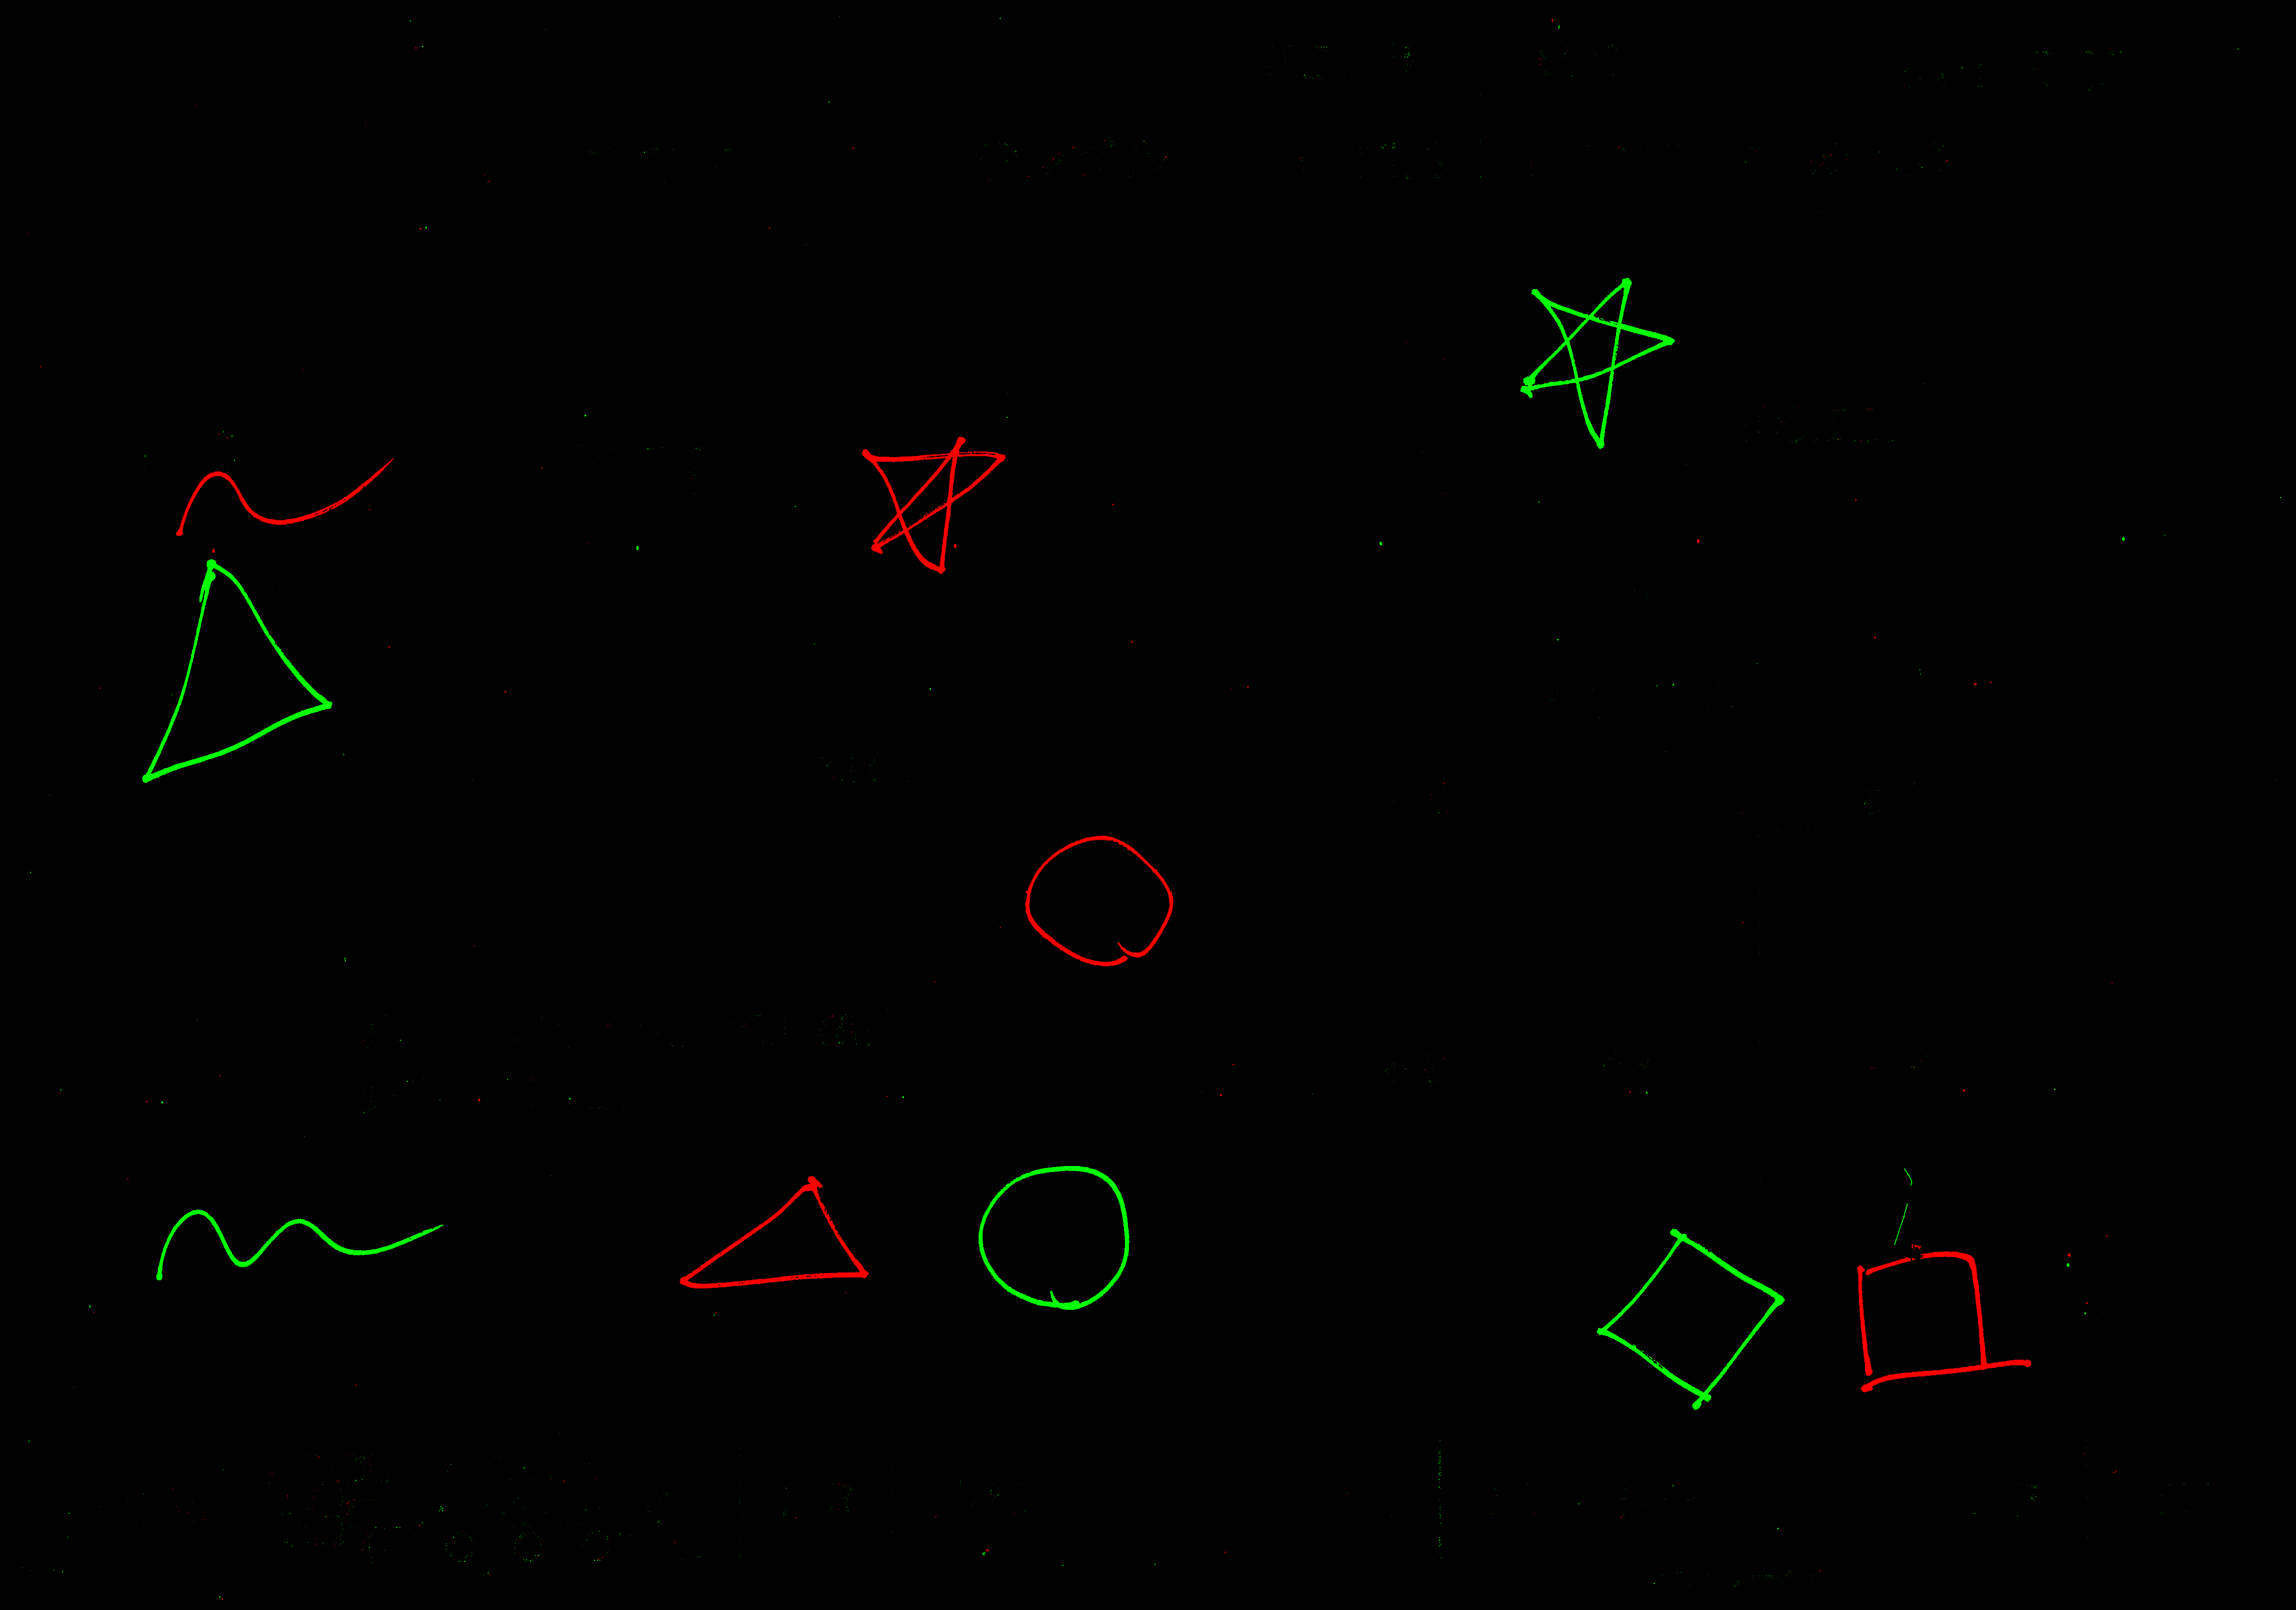

In [133]:
disp(sub)

上の画像を元のblur1と重ねるために、まずマスク用の画像を作る。

In [158]:
gsub=gray(sub)
csub=color(gsub)

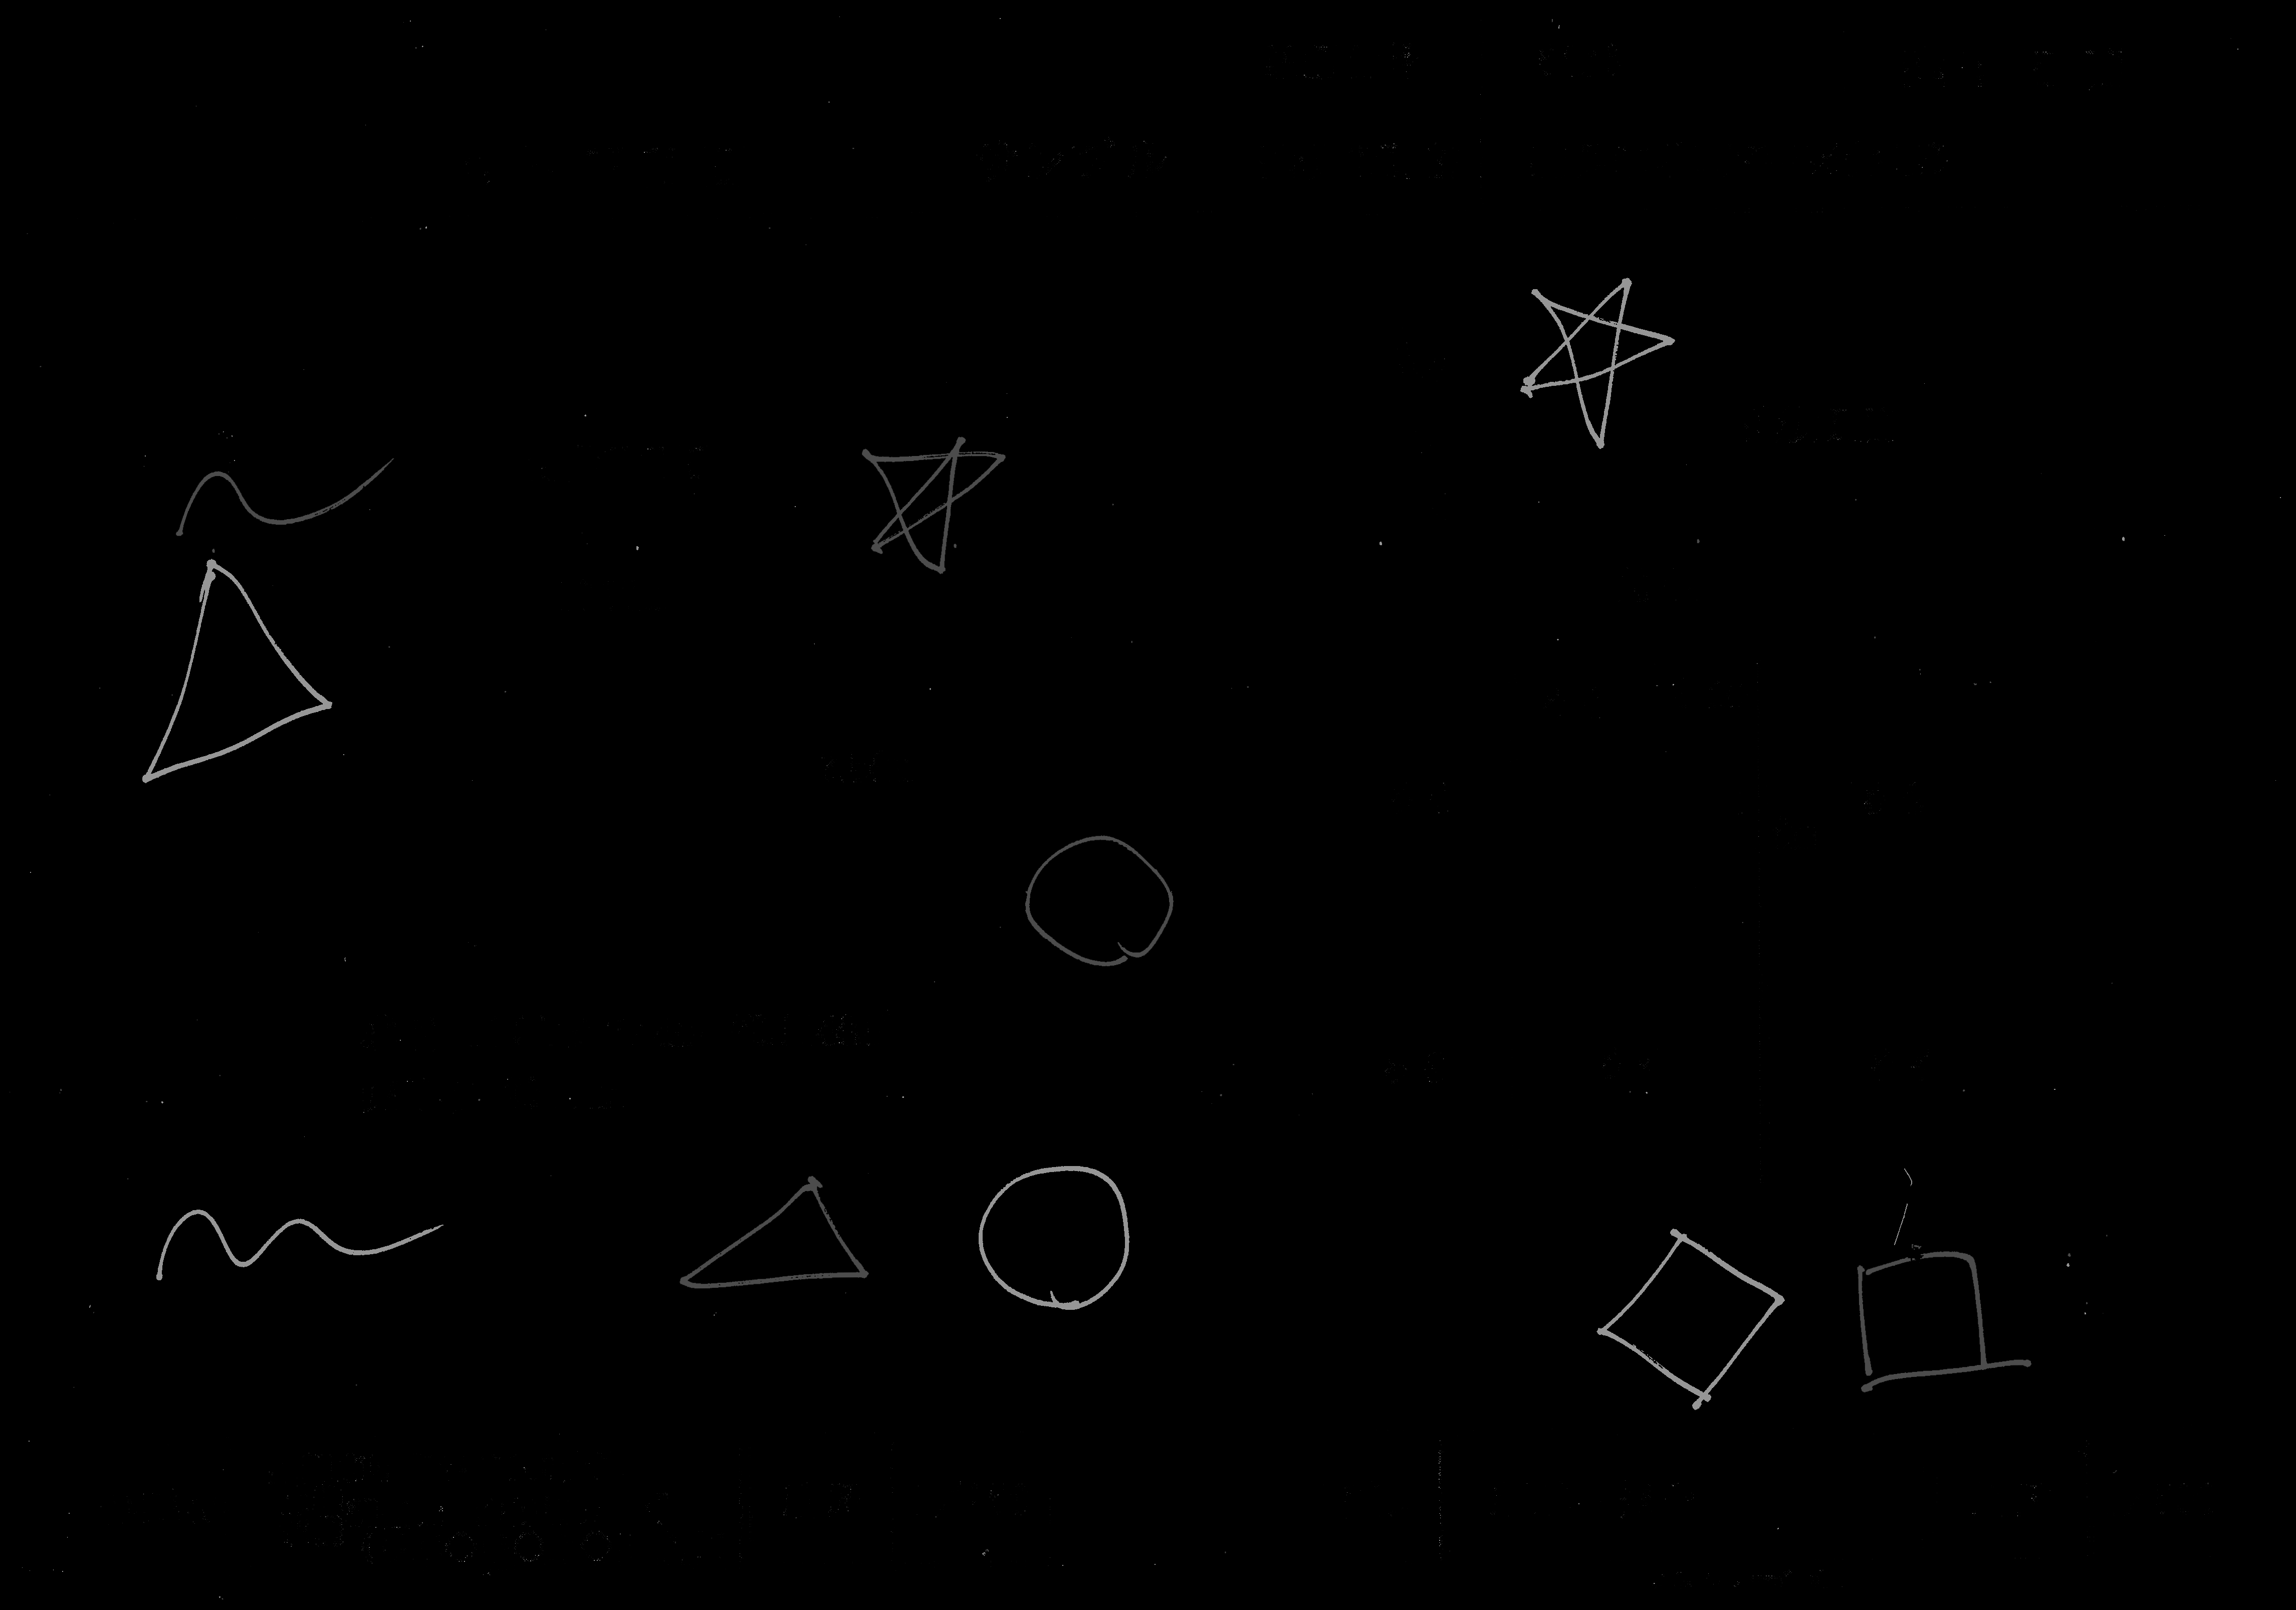

In [159]:
disp(csub)

画像の重ね合わせにnp.whereを使う。

In [163]:
pile=np.where(csub==0,blur1,sub)

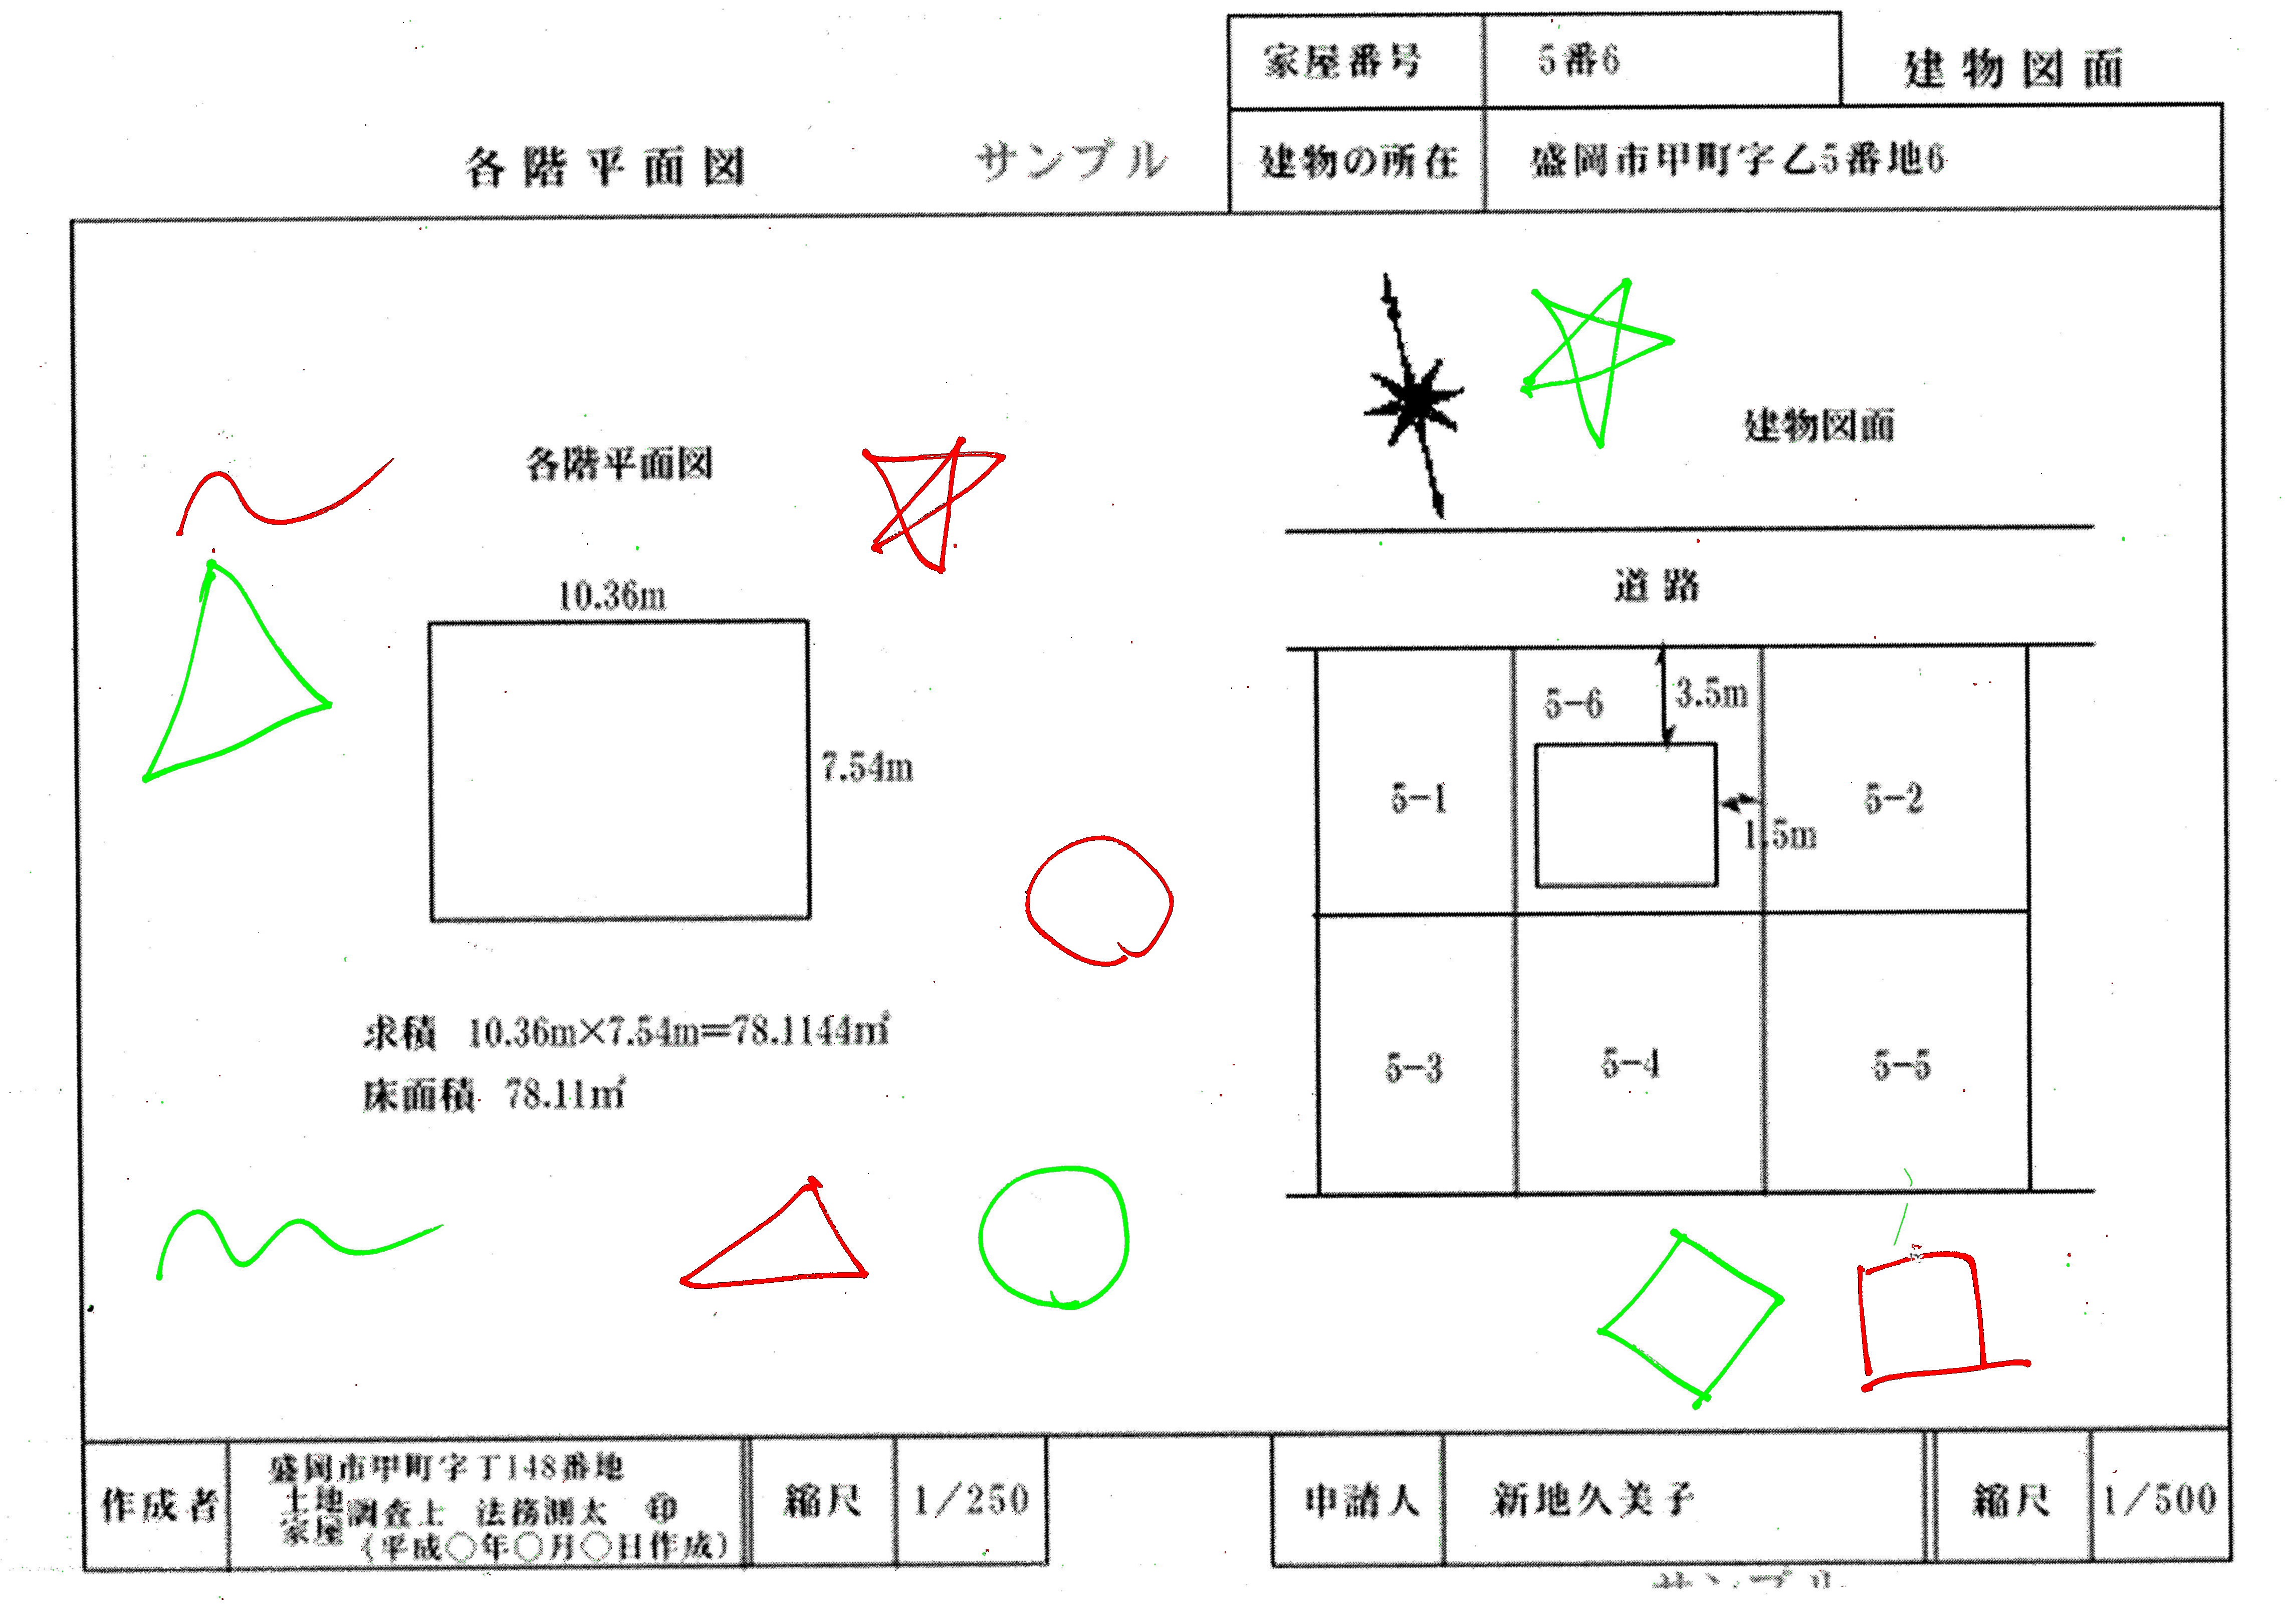

In [164]:
disp(pile)